In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

import os
import cv2
import glob
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

from datetime import datetime
from datetime import time

## Making lists of dataset files

In [ ]:
train_jsons = sorted(glob.glob('/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Training/train_objects_labeling/*'))

## Loading training meta data (json) 

In [ ]:
train_meta = []
for j in train_jsons:
    json_obj = json.load(open(j))
    # json_obj['features']
    for f in json_obj['features']:
        # geometry
        geo_coord = f['geometry']['coordinates']
        geo_type = f['geometry']['type']
        # properties
        object_imcoords = f['properties']['object_imcoords']
        object_angle = f['properties']['object_angle']
        building_imcoords = f['properties']['building_imcoords']
        road_imcoords = f['properties']['road_imcoords'] 
        image_id = f['properties']['image_id'] # 영상 ID
        ingest_time = f['properties']['ingest_time'] # 	영상 생성 시간
        type_id = f['properties']['type_id'] # 정수 (1~N), 클래스 id
        type_name = f['properties']['type_name'] # 클래스 이름

        # add to list
        train_meta.append([image_id, type_id, type_name, geo_coord, geo_type, object_angle,
                           object_imcoords, building_imcoords, road_imcoords, ingest_time])
# Make dataframe
df_train = pd.DataFrame(train_meta,
                        columns = ['image_id','type_id','type_name','geo_coord','geo_type','object_angle',
                                   'object_imcoords','building_imcoords','road_imcoords','ingest_time'])

In [ ]:
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/df_train.csv', mode='w')

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_train.csv')

In [ ]:
df_train.head(5)

Unnamed: 0  ...                  ingest_time
0           0  ...  2020-11-20T03:01:18.829265Z
1           1  ...  2020-11-20T03:01:18.829265Z
2           2  ...  2020-11-20T03:01:18.829265Z
3           3  ...  2020-11-20T03:01:18.829265Z
4           4  ...  2020-11-20T03:01:18.829265Z

[5 rows x 11 columns]

In [ ]:
df_train.shape

(423750, 11)

In [ ]:
# 인덱스 확인
df_train.index

RangeIndex(start=0, stop=423750, step=1)

In [ ]:
# columns 확인
df_train.columns

Index(['Unnamed: 0', 'image_id', 'type_id', 'type_name', 'geo_coord',
       'geo_type', 'object_angle', 'object_imcoords', 'building_imcoords',
       'road_imcoords', 'ingest_time'],
      dtype='object')

In [ ]:
# class 확인
df_train['type_name'].unique()

array(['civilian aircraft', 'small car', 'truck', 'grouped container',
       'individual container', 'large ship', 'small ship', 'bus',
       'oil tank', 'crane', 'indoor playground', 'bridge', 'roundabout',
       'outdoor playground', 'swimming pool', 'helipad', 'train',
       'military aircraft', 'etc', 'dam', 'helicopter'], dtype=object)

In [ ]:
# class 개수 확인
df_train['type_name'].nunique()

21

In [ ]:
# 각 열의 데이터 타입 확인
df_train.dtypes

Unnamed: 0             int64
image_id              object
type_id                int64
type_name             object
geo_coord             object
geo_type              object
object_angle         float64
object_imcoords       object
building_imcoords     object
road_imcoords         object
ingest_time           object
dtype: object

In [ ]:
df_train.info

<bound method DataFrame.info of         Unnamed: 0  ...                  ingest_time
0                0  ...  2020-11-20T03:01:18.829265Z
1                1  ...  2020-11-20T03:01:18.829265Z
2                2  ...  2020-11-20T03:01:18.829265Z
3                3  ...  2020-11-20T03:01:18.829265Z
4                4  ...  2020-11-20T03:01:18.829265Z
...            ...  ...                          ...
423745      423745  ...  2020-11-04T06:55:45.982142Z
423746      423746  ...  2020-11-04T07:00:10.231724Z
423747      423747  ...  2020-11-04T07:00:10.231724Z
423748      423748  ...  2020-11-04T06:58:44.814786Z
423749      423749  ...  2020-11-04T06:53:36.815709Z

[423750 rows x 11 columns]>

In [ ]:
# null 값 확인
df_train.isnull().sum()

Unnamed: 0           0
image_id             0
type_id              0
type_name            0
geo_coord            0
geo_type             0
object_angle         0
object_imcoords      0
building_imcoords    0
road_imcoords        0
ingest_time          0
dtype: int64

### ingest_time column을 datatime으로 변환

In [ ]:
df_train['ingest_time']

0         2020-11-20T03:01:18.829265Z
1         2020-11-20T03:01:18.829265Z
2         2020-11-20T03:01:18.829265Z
3         2020-11-20T03:01:18.829265Z
4         2020-11-20T03:01:18.829265Z
                     ...             
423745    2020-11-04T06:55:45.982142Z
423746    2020-11-04T07:00:10.231724Z
423747    2020-11-04T07:00:10.231724Z
423748    2020-11-04T06:58:44.814786Z
423749    2020-11-04T06:53:36.815709Z
Name: ingest_time, Length: 423750, dtype: object

In [ ]:
df_train['ingest_time'].value_counts()

2020-11-04T06:52:57.096088Z    1891
2020-11-16T01:24:43.811354Z    1647
2020-11-04T07:06:13.482718Z    1537
2020-11-17T04:59:38.927196Z    1495
2020-11-12T02:31:42.999943Z    1477
                               ... 
2020-11-04T06:58:57.796547Z       1
2020-11-04T06:55:10.152147Z       1
2020-11-04T07:02:45.692415Z       1
2020-11-04T06:53:36.815709Z       1
2020-11-04T06:57:03.858701Z       1
Name: ingest_time, Length: 1748, dtype: int64

In [ ]:
# 날짜 형태로 split
df_train['ingest_date'] = df_train.ingest_time.str.split('T').str[0]
print(df_train['ingest_date'])
print(type(df_train['ingest_date']))

0         2020-11-20
1         2020-11-20
2         2020-11-20
3         2020-11-20
4         2020-11-20
             ...    
423745    2020-11-04
423746    2020-11-04
423747    2020-11-04
423748    2020-11-04
423749    2020-11-04
Name: ingest_date, Length: 423750, dtype: object
<class 'pandas.core.series.Series'>


In [ ]:
# 날짜 시간 형태로 split
df_train['ingest_time'] = df_train.ingest_time.str.split('T').str[1]
df_train['ingest_time'] = df_train['ingest_date'] + ' ' + df_train.ingest_time.str.split('.').str[0]
print(df_train['ingest_time'])

0         2020-11-20 03:01:18
1         2020-11-20 03:01:18
2         2020-11-20 03:01:18
3         2020-11-20 03:01:18
4         2020-11-20 03:01:18
                 ...         
423745    2020-11-04 06:55:45
423746    2020-11-04 07:00:10
423747    2020-11-04 07:00:10
423748    2020-11-04 06:58:44
423749    2020-11-04 06:53:36
Name: ingest_time, Length: 423750, dtype: object


In [ ]:
# datatime type으로 변환 - ingest_date
df_train['ingest_date'] = pd.to_datetime(df_train['ingest_date'])
print(df_train['ingest_date'])
print(type(df_train['ingest_date']))

0        2020-11-20
1        2020-11-20
2        2020-11-20
3        2020-11-20
4        2020-11-20
            ...    
423745   2020-11-04
423746   2020-11-04
423747   2020-11-04
423748   2020-11-04
423749   2020-11-04
Name: ingest_date, Length: 423750, dtype: datetime64[ns]
<class 'pandas.core.series.Series'>


In [ ]:
# datatime type으로 변환 - ingest_time
df_train['ingest_time'] = pd.to_datetime(df_train['ingest_time'])
print(df_train['ingest_time'])
print(type(df_train['ingest_time']))

0        2020-11-20 03:01:18
1        2020-11-20 03:01:18
2        2020-11-20 03:01:18
3        2020-11-20 03:01:18
4        2020-11-20 03:01:18
                 ...        
423745   2020-11-04 06:55:45
423746   2020-11-04 07:00:10
423747   2020-11-04 07:00:10
423748   2020-11-04 06:58:44
423749   2020-11-04 06:53:36
Name: ingest_time, Length: 423750, dtype: datetime64[ns]
<class 'pandas.core.series.Series'>


In [ ]:
df_train.dtypes

Unnamed: 0                    int64
image_id                     object
type_id                       int64
type_name                    object
geo_coord                    object
geo_type                     object
object_angle                float64
object_imcoords              object
building_imcoords            object
road_imcoords                object
ingest_time          datetime64[ns]
ingest_date          datetime64[ns]
dtype: object

In [ ]:
df_train

Unnamed: 0  ... ingest_date
0                0  ...  2020-11-20
1                1  ...  2020-11-20
2                2  ...  2020-11-20
3                3  ...  2020-11-20
4                4  ...  2020-11-20
...            ...  ...         ...
423745      423745  ...  2020-11-04
423746      423746  ...  2020-11-04
423747      423747  ...  2020-11-04
423748      423748  ...  2020-11-04
423749      423749  ...  2020-11-04

[423750 rows x 12 columns]

### 동일한 값을 갖는 컬럼들 확인

In [ ]:
df_train['geo_coord'].map(lambda x: str(x)).value_counts()

[[-99.2560382272, 19.5671796469, 0.0], [-99.250668751, 19.5671871844, 0.0], [-99.2506766199, 19.572276843, 0.0], [-99.2560462646, 19.5722693034, 0.0]]          1891
[[174.8172155564, -36.9081672643, 0.0], [174.8235331716, -36.9082832225, 0.0], [174.8236773429, -36.9032098873, 0.0], [174.8173601455, -36.9030939503, 0.0]]    1647
[[3.3548804675, 6.6122769696, 0.0], [3.3599753707, 6.6122733098, 0.0], [3.3599790581, 6.6173679768, 0.0], [3.3548841028, 6.6173716394, 0.0]]                    1537
[[143.1950957431, 42.8865178266, 0.0], [143.201987691, 42.8863854156, 0.0], [143.2021680601, 42.8914534288, 0.0], [143.1952755487, 42.8915858631, 0.0]]         1495
[[149.1880353012, -35.3169637695, 0.0], [149.1942266835, -35.3168515248, 0.0], [149.1940895617, -35.3117769001, 0.0], [149.1878985656, -35.3118891238, 0.0]]    1477
                                                                                                                                                                ... 
[[-52.0013

In [ ]:
df_train['geo_type'].value_counts()

Polygon    423750
Name: geo_type, dtype: int64

In [ ]:
df_train['building_imcoords'].value_counts()

EMPTY    423750
Name: building_imcoords, dtype: int64

In [ ]:
df_train['road_imcoords'].value_counts()

EMPTY    423750
Name: road_imcoords, dtype: int64

### 불필요 컬럼 제거 : 동일한 항목 4개

In [ ]:
df_train = df_train[['image_id','type_id', 'geo_coord', 'type_name','object_angle','object_imcoords', 'ingest_time', 'ingest_date']]
df_train = df_train.sort_values(by = ['image_id','type_id']).reset_index(drop=True)
df_train.head(10)

image_id  type_id  ...         ingest_time ingest_date
0  OBJ00013_PS3_K3_NIA0078.png        3  ... 2020-11-20 03:01:18  2020-11-20
1  OBJ00013_PS3_K3_NIA0078.png        5  ... 2020-11-20 03:01:18  2020-11-20
2  OBJ00013_PS3_K3_NIA0078.png        5  ... 2020-11-20 03:01:18  2020-11-20
3  OBJ00013_PS3_K3_NIA0078.png        5  ... 2020-11-20 03:01:18  2020-11-20
4  OBJ00013_PS3_K3_NIA0078.png        5  ... 2020-11-20 03:01:18  2020-11-20
5  OBJ00013_PS3_K3_NIA0078.png        5  ... 2020-11-20 03:01:18  2020-11-20
6  OBJ00013_PS3_K3_NIA0078.png        5  ... 2020-11-20 03:01:18  2020-11-20
7  OBJ00013_PS3_K3_NIA0078.png        7  ... 2020-11-20 03:01:18  2020-11-20
8  OBJ00013_PS3_K3_NIA0078.png        7  ... 2020-11-20 03:01:18  2020-11-20
9  OBJ00013_PS3_K3_NIA0078.png        7  ... 2020-11-20 03:01:18  2020-11-20

[10 rows x 8 columns]

## Objects distribution per training images (1748)

파일별 기록된 객체 정보가 정리된 데이터프레임

In [ ]:
print('학습용 데이터 개수:', len(glob.glob('/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Training/train_objects_data/*')))
print('학습용 라벨 개수:', len(glob.glob('/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Training/train_objects_labeling/*')))
print('검증용 데이터 개수:', len(glob.glob('/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Validation/validate_objects_data/*')))

학습용 데이터 개수: 5244
학습용 라벨 개수: 1748
검증용 데이터 개수: 660


In [ ]:
df_image = df_train.image_id.value_counts().to_frame(name = 'obj_count') # obj 카운터 컬럼 넣기
df_image = df_image.join(df_train[['type_name','image_id']].drop_duplicates()['image_id'].value_counts()).rename(columns = {'image_id':'obj_nunique'})
df_img2obj = df_image.join(pd.crosstab(df_train['image_id'], df_train['type_name'])[df_train['type_name'].value_counts().index])
df_img2obj.head(10)

obj_count  obj_nunique  ...  dam  indoor playground
OBJ05158_PS3_K3A_NIA0336.png       1891            3  ...    0                  0
OBJ03758_PS3_K3A_NIA0157.png       1647            6  ...    0                  0
OBJ03826_PS3_K3A_NIA0160.png       1537            3  ...    0                  0
OBJ04665_PS3_K3A_NIA0310.png       1495            2  ...    0                  0
OBJ04798_PS3_K3A_NIA0315.png       1477            6  ...    0                  0
OBJ04987_PS3_K3A_NIA0328.png       1475            4  ...    0                  0
OBJ04053_PS3_K3A_NIA0170.png       1417            4  ...    0                  0
OBJ03429_PS3_K3A_NIA0139.png       1344            6  ...    0                  0
OBJ04355_PS3_K3A_NIA0284.png       1321            4  ...    0                  0
OBJ04176_PS3_K3A_NIA0180.png       1317            5  ...    0                  1

[10 rows x 23 columns]

In [ ]:
train_labels = glob.glob('/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Training/train_objects_labeling/*')

In [ ]:
df_img2obj.sum().sort_values()

indoor playground           43
dam                        164
helicopter                 184
bridge                     266
outdoor playground         276
helipad                    309
roundabout                 371
crane                      496
large ship                 546
civilian aircraft          875
military aircraft         1298
etc                       1542
oil tank                  1631
swimming pool             2188
individual container      5959
obj_nunique               6826
grouped container         8069
bus                       8698
train                    10331
small ship               19238
truck                    27067
small car               334199
obj_count               423750
dtype: int64

In [ ]:
total_df = df_img2obj.drop(['obj_count','obj_nunique'], axis=1)
total_df

small car  truck  ...  dam  indoor playground
OBJ05158_PS3_K3A_NIA0336.png       1874     16  ...    0                  0
OBJ03758_PS3_K3A_NIA0157.png       1530     97  ...    0                  0
OBJ03826_PS3_K3A_NIA0160.png       1492     38  ...    0                  0
OBJ04665_PS3_K3A_NIA0310.png       1489      6  ...    0                  0
OBJ04798_PS3_K3A_NIA0315.png       1460      2  ...    0                  0
...                                 ...    ...  ...  ...                ...
OBJ05842_PS3_K3_NIA0601.png           0      0  ...    1                  0
OBJ07450_PS3_K3A_NIA0834.png          0      0  ...    1                  0
OBJ06295_PS3_K3_NIA0647.png           0      0  ...    1                  0
OBJ06525_PS3_K3_NIA0682.png           0      0  ...    1                  0
OBJ04623_PS3_K3A_NIA0303.png          0      0  ...    0                  0

[1748 rows x 21 columns]

파일별 기록된 객체 정보가 정리된 데이터프레임입니다.

가령 `OBJ05158_PS3_K3A_NIA0336.png` 파일에는 `small car` 1874대, `truck`이 16대, `bus` 1대가 기록되어 있습니다.

In [ ]:
print('훈련셋 내에 총 object 개수:', total_df.sum().sum())
print('train set 내의 object 분포 비율')
total_df.sum().sort_values() / total_df.sum().sum()
df_object['obj_count'].sum().sort_values() / df_object['obj_count'].sum().sum()

훈련셋 내에 총 object 개수: 423750
train set 내의 object 분포 비율


indoor playground       0.000101
dam                     0.000387
helicopter              0.000434
bridge                  0.000628
outdoor playground      0.000651
helipad                 0.000729
roundabout              0.000876
crane                   0.001171
large ship              0.001288
civilian aircraft       0.002065
military aircraft       0.003063
etc                     0.003639
oil tank                0.003849
swimming pool           0.005163
individual container    0.014063
grouped container       0.019042
bus                     0.020526
train                   0.024380
small ship              0.045399
truck                   0.063875
small car               0.788670
dtype: float64

- object들이 불균등하게 분포 되어 있는 것을 확인
- 131,436 객체들 중 78%가 small car로 구성됨

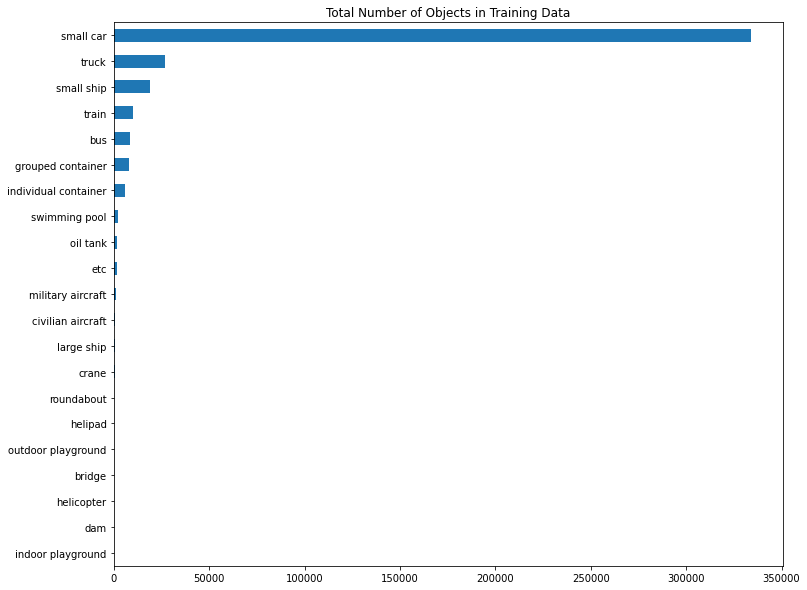

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
total_df.sum().sort_values().plot(kind = 'barh', title = 'Total Number of Objects in Training Data')

### Training Image들의 객체 분포
* X축 : Image 1748장을 포함된 객체의 빈도 순으로 정렬
* Y축 : 빈도가 높은 객체유형 순으로 정렬

<br></br>
#### Sparse & Imbalanced => Data Augmentation이 중요한 상황 

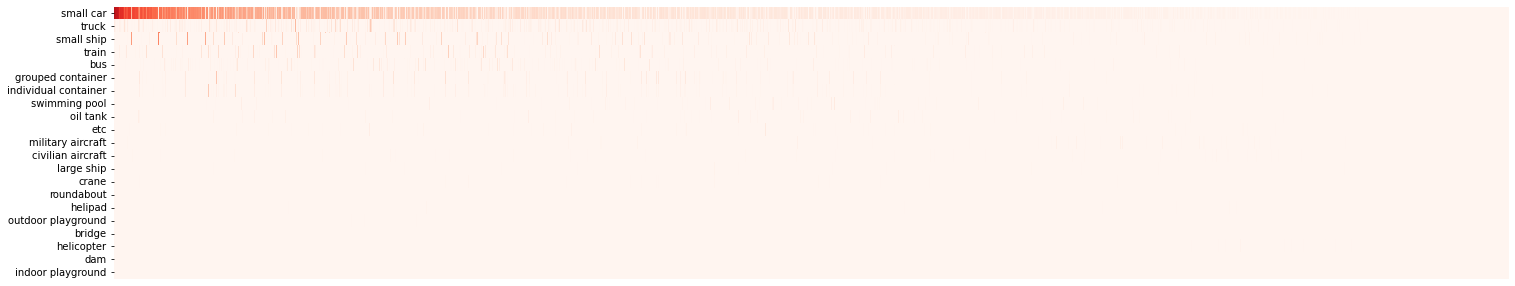

In [ ]:
plt.figure(figsize = (25,5))
ax = sns.heatmap(df_img2obj.iloc[:,2:].transpose(), cmap='Reds', cbar=False, xticklabels=False)

### Objects per single Image
* 사진1장에 포함된 객체수의 분포
* 전체 분포와 'small car' 분포가 별 차이가 없음

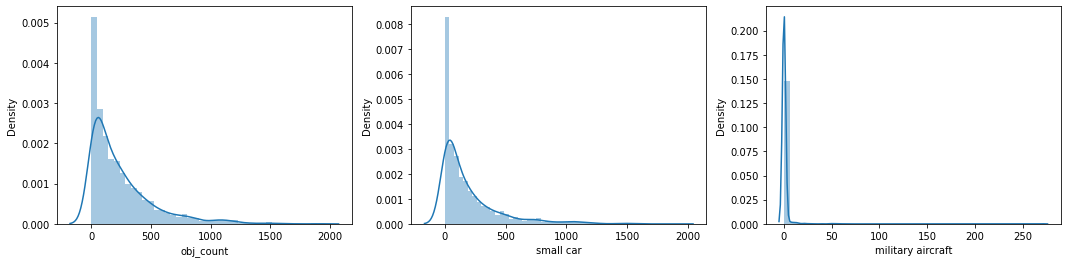

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
sns.distplot(df_img2obj['obj_count'], ax=axs[0])
sns.distplot(df_img2obj['small car'], ax=axs[1])
sns.distplot(df_img2obj['military aircraft'], ax=axs[2])
plt.show()

### Image에 포함된 고유한 객체유형수 1~10
* 고유한 객체유형(type_id)은 10개

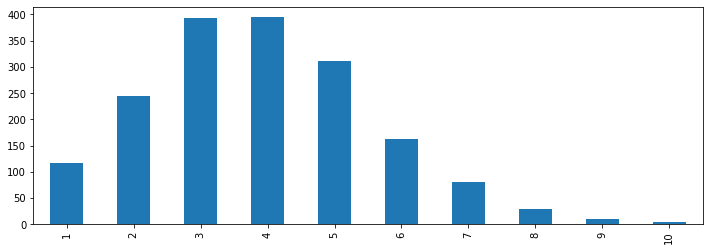

In [ ]:
df_img2obj['obj_nunique'].value_counts().sort_index().plot.bar(figsize=(12,4))
plt.show()

## 객체유형별 전체 객체수(obj_count), 객체를 포함하는 이미지수(image_count)

In [ ]:
df_object = df_train.type_name.value_counts().to_frame(name = 'obj_count')
df_object = df_object.join(df_train[['type_name','image_id']].drop_duplicates()['type_name'].value_counts()).rename(columns = {'type_name':'image_count'})
#df_object.plot.barh(figsize=(12,6))

In [ ]:
df_object

obj_count  image_count
small car                334199         1623
truck                     27067         1317
small ship                19238          294
train                     10331          154
bus                        8698          827
grouped container          8069          322
individual container       5959          347
swimming pool              2188          194
oil tank                   1631          117
etc                        1542          230
military aircraft          1298           85
civilian aircraft           875          147
large ship                  546          169
crane                       496           99
roundabout                  371          275
helipad                     309          122
outdoor playground          276          114
bridge                      266          165
helicopter                  184           35
dam                         164          150
indoor playground            43           40

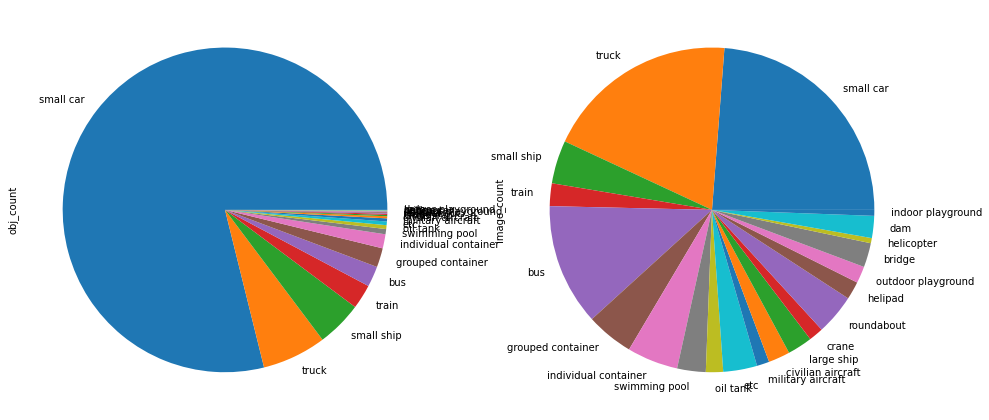

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
df_object['obj_count'].plot.pie(ax=axs[0])
df_object['image_count'].plot.pie(ax=axs[1])

### Split Object Coordinates

In [ ]:
imcoords_columns = []
for i in range(4):
    df_train['p{}_x'.format(i+1)] = 0.0
    df_train['p{}_y'.format(i+1)] = 0.0
    imcoords_columns.append('p{}_x'.format(i+1))
    imcoords_columns.append('p{}_y'.format(i+1))

# Parse 'object_imcoords'
df_train[imcoords_columns] = df_train.apply(lambda x: list(map(float, x['object_imcoords'].split(','))), axis=1, result_type='expand')
df_train.head(3)

image_id  type_id  ...        p4_x        p4_y
0  OBJ00013_PS3_K3_NIA0078.png        3  ...  469.182093  563.548958
1  OBJ00013_PS3_K3_NIA0078.png        5  ...  990.144842  331.189117
2  OBJ00013_PS3_K3_NIA0078.png        5  ...  985.495386  325.763553

[3 rows x 16 columns]

In [ ]:
df_train['type_id'] = df_train['type_id'].astype(int)

df_types = df_train[['type_id','type_name']].drop_duplicates().sort_values(by='type_id').reset_index(drop=True)
df_types.index = df_types.index + 1

# type_id : type_name
type_name_dict = df_types['type_name'].to_dict()

# Object Type : Color (plt.cm.tab20b)
type_colors = dict(zip(type_name_dict.keys(), plt.cm.tab20.colors))

### Display Image & Objects
* 사진과 객체를 출력해주는 유틸리티 함수 

In [ ]:
def show_n_mask(image_id, obj_type=None, gray_mode=True):
    fig= plt.figure(figsize=(18,18))
    # plot image
    img = cv2.imread('/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Training/train_objects_data/'+image_id, cv2.COLOR_BGR2RGB)
    if gray_mode:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    else:
        plt.imshow(img)
    
    # All object or selected objects(obj_type)
    for idx, row in df_train[df_train.image_id == image_id][['type_id','type_name']+imcoords_columns].iterrows():
        if (obj_type==row.type_name):
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
        elif obj_type == None:
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
    plt.show()

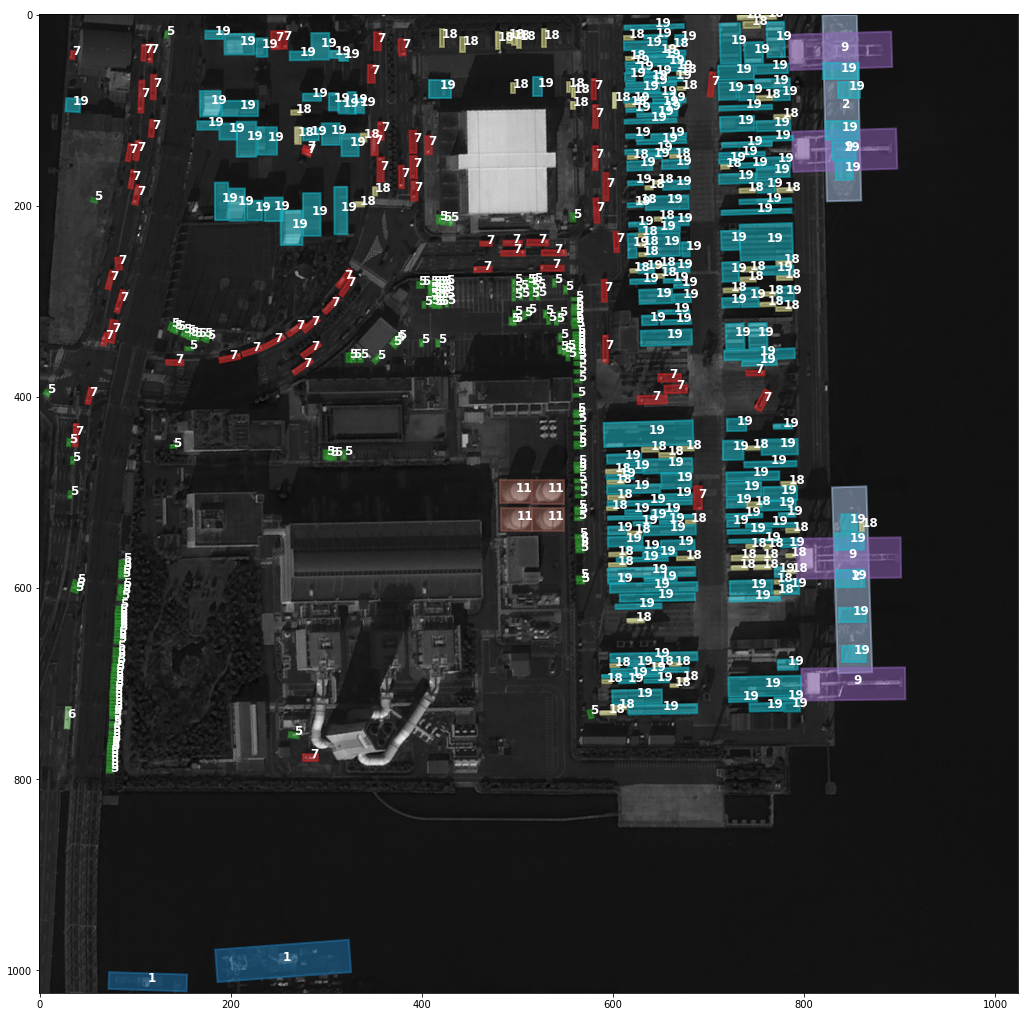

In [ ]:
show_n_mask('OBJ00028_PS3_K3_NIA0078.png')

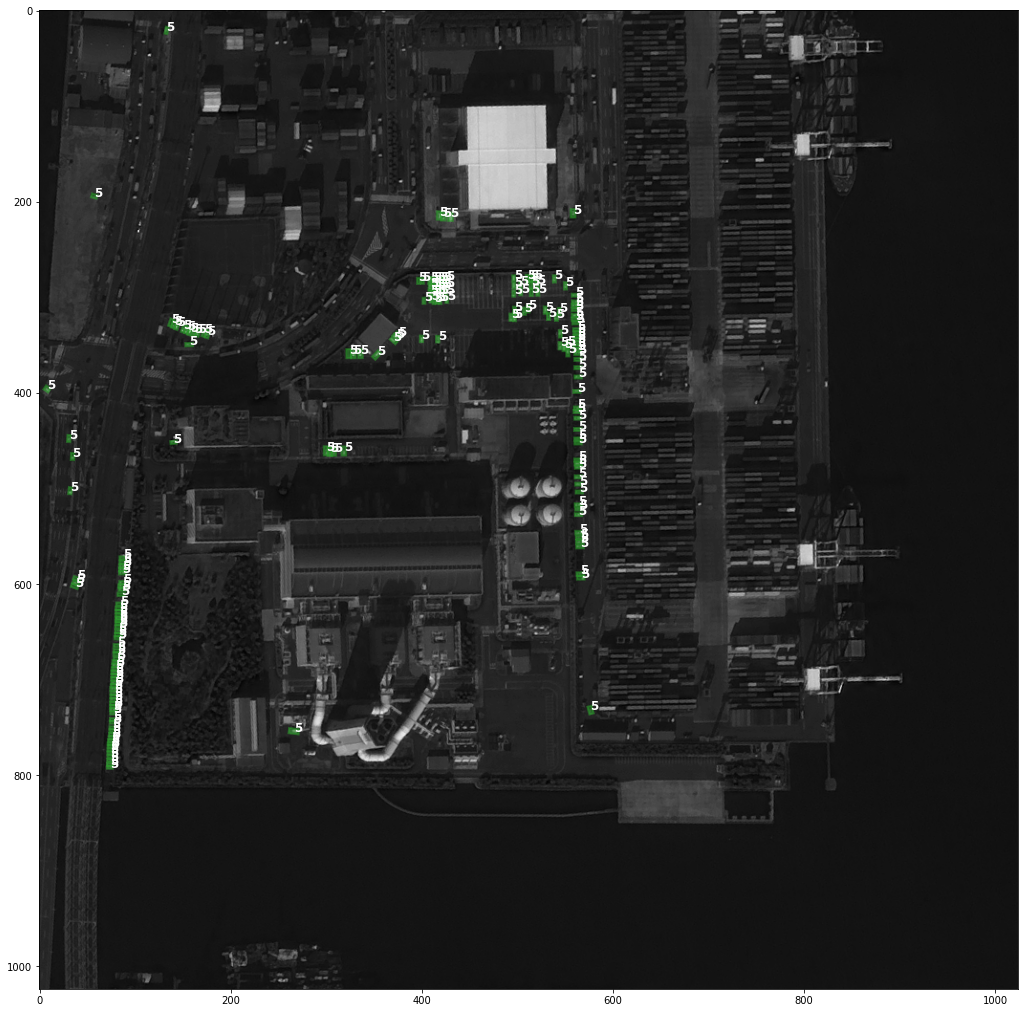

In [ ]:
# 1 object('small car')만 확인
show_n_mask('OBJ00028_PS3_K3_NIA0078.png', 'small car')

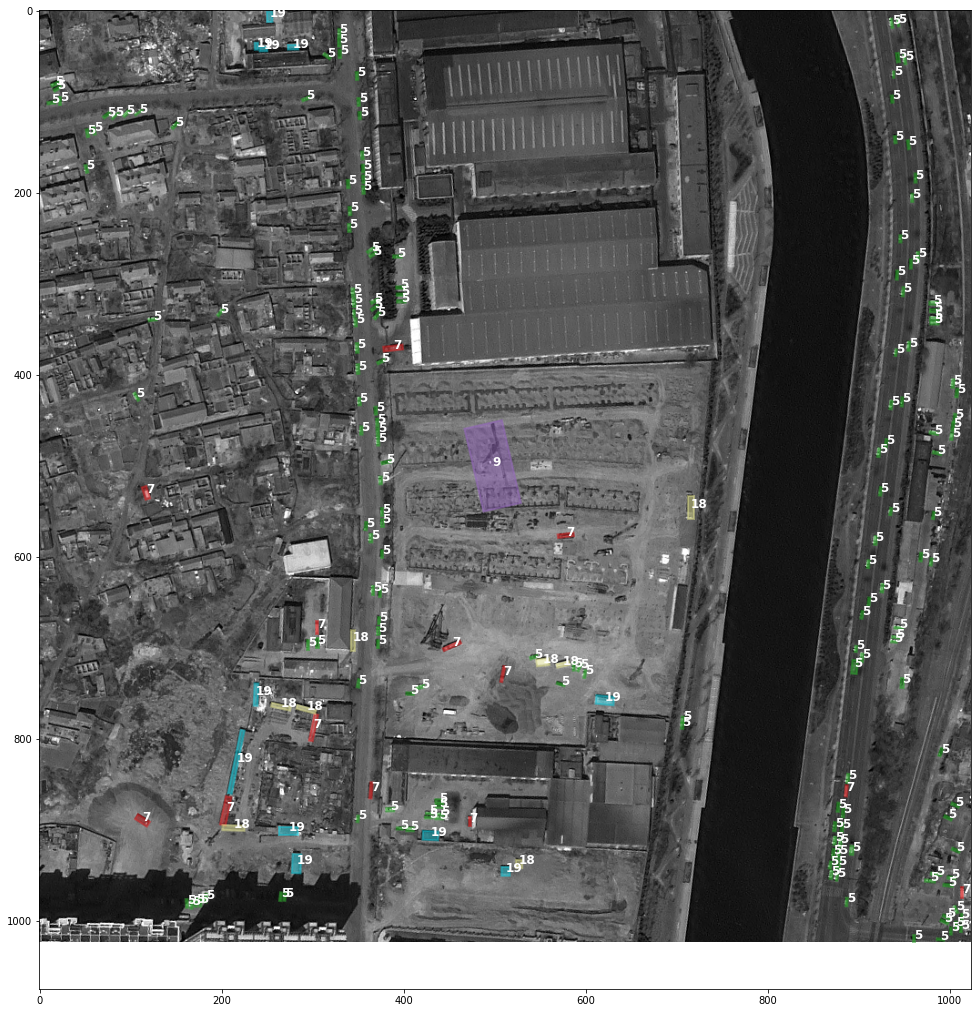

In [ ]:
show_n_mask('OBJ03570_PS3_K3A_NIA0150.png')

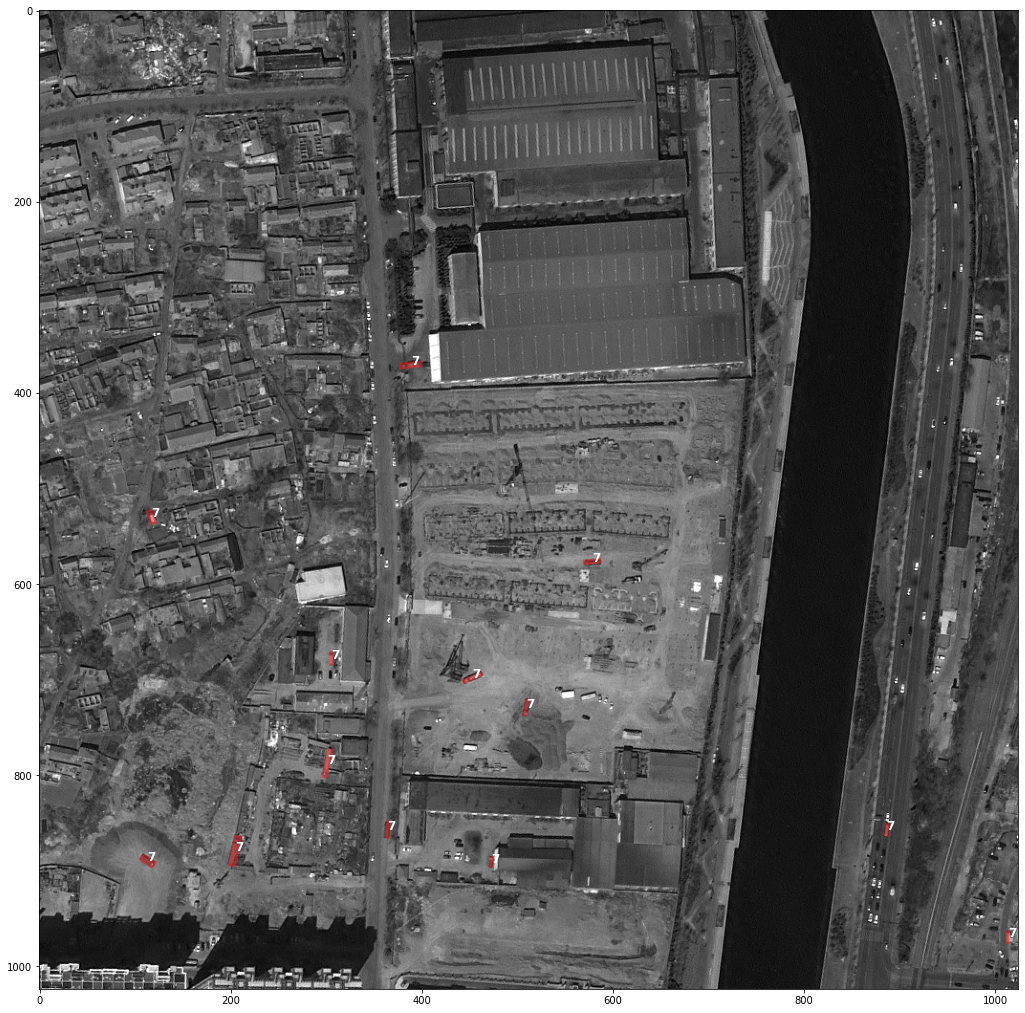

In [ ]:
# 1 object('truck')만 확인
show_n_mask('OBJ03570_PS3_K3A_NIA0150.png', 'truck')

## ingest_time을 활용한 date 분포 확인

In [ ]:
df_date = df_train[['ingest_time', 'ingest_date']]
print(df_date)

               ingest_time ingest_date
0      2020-11-20 03:01:18  2020-11-20
1      2020-11-20 03:01:18  2020-11-20
2      2020-11-20 03:01:18  2020-11-20
3      2020-11-20 03:01:18  2020-11-20
4      2020-11-20 03:01:18  2020-11-20
...                    ...         ...
423745 2020-11-04 06:55:45  2020-11-04
423746 2020-11-04 07:00:10  2020-11-04
423747 2020-11-04 07:00:10  2020-11-04
423748 2020-11-04 06:58:44  2020-11-04
423749 2020-11-04 06:53:36  2020-11-04

[423750 rows x 2 columns]


In [ ]:
df_date['ingest_time'].value_counts()

2020-11-04 06:52:57    1891
2020-11-04 07:03:49    1860
2020-11-16 01:24:43    1647
2020-11-04 07:06:13    1537
2020-11-17 04:59:38    1495
                       ... 
2020-11-04 07:01:06       1
2020-11-04 06:58:03       1
2020-11-04 07:06:25       1
2020-11-04 07:08:49       1
2020-11-04 06:55:12       1
Name: ingest_time, Length: 1525, dtype: int64

In [ ]:
# 날짜는 2020-11-04부터 2020-11-23까지
df_date.sort_values('ingest_date')

ingest_time ingest_date
211874 2020-11-04 06:55:00  2020-11-04
211116 2020-11-04 07:02:24  2020-11-04
211117 2020-11-04 07:02:24  2020-11-04
211118 2020-11-04 07:02:24  2020-11-04
211119 2020-11-04 07:02:24  2020-11-04
...                    ...         ...
7659   2020-11-23 06:19:31  2020-11-23
7658   2020-11-23 06:19:31  2020-11-23
7657   2020-11-23 06:19:31  2020-11-23
7655   2020-11-23 06:19:31  2020-11-23
362063 2020-11-23 06:53:45  2020-11-23

[423750 rows x 2 columns]

In [ ]:
# 2020-11-04 06:51:05부터 2020-11-23 08:52:08까지
df_date.sort_values('ingest_time', inplace=True)
print(df_date['ingest_time'].head())
print(df_date['ingest_time'].tail())

159130   2020-11-04 06:51:05
158961   2020-11-04 06:51:05
158960   2020-11-04 06:51:05
158959   2020-11-04 06:51:05
158958   2020-11-04 06:51:05
Name: ingest_time, dtype: datetime64[ns]
9728    2020-11-23 08:52:08
9729    2020-11-23 08:52:08
9730    2020-11-23 08:52:08
10404   2020-11-23 08:52:08
10000   2020-11-23 08:52:08
Name: ingest_time, dtype: datetime64[ns]


In [ ]:
df_date['ingest_time'].value_counts()

2020-11-04 06:52:57    1891
2020-11-04 07:03:49    1860
2020-11-16 01:24:43    1647
2020-11-04 07:06:13    1537
2020-11-17 04:59:38    1495
                       ... 
2020-11-04 07:01:06       1
2020-11-04 07:07:45       1
2020-11-04 06:52:00       1
2020-11-04 07:08:49       1
2020-11-04 07:06:25       1
Name: ingest_time, Length: 1525, dtype: int64

In [ ]:
df_date['year'] = df_date['ingest_time'].dt.year
df_date['month'] = df_date['ingest_time'].dt.month
df_date['week'] = df_date['ingest_time'].dt.week
df_date['day'] = df_date['ingest_time'].dt.weekday

In [ ]:
print(df_date)

               ingest_time ingest_date  year  month  week  day
159130 2020-11-04 06:51:05  2020-11-04  2020     11    45    2
158961 2020-11-04 06:51:05  2020-11-04  2020     11    45    2
158960 2020-11-04 06:51:05  2020-11-04  2020     11    45    2
158959 2020-11-04 06:51:05  2020-11-04  2020     11    45    2
158958 2020-11-04 06:51:05  2020-11-04  2020     11    45    2
...                    ...         ...   ...    ...   ...  ...
9728   2020-11-23 08:52:08  2020-11-23  2020     11    48    0
9729   2020-11-23 08:52:08  2020-11-23  2020     11    48    0
9730   2020-11-23 08:52:08  2020-11-23  2020     11    48    0
10404  2020-11-23 08:52:08  2020-11-23  2020     11    48    0
10000  2020-11-23 08:52:08  2020-11-23  2020     11    48    0

[423750 rows x 6 columns]


In [ ]:
df_date['ingest_hour'] = df_date['ingest_time'].dt.hour
df_train['ingest_hour'] = df_date['ingest_hour']
df_date['ingest_hour']

159130    6
158961    6
158960    6
158959    6
158958    6
         ..
9728      8
9729      8
9730      8
10404     8
10000     8
Name: ingest_hour, Length: 423750, dtype: int64

In [ ]:
# 시간대는 00-08시까지
df_date['ingest_hour'].value_counts()

6    127000
7    115346
8     41396
5     38966
1     27311
4     25839
2     25760
3     20080
0      2052
Name: ingest_hour, dtype: int64

In [ ]:
len_df = len(df_date['ingest_hour'])
len_df

423750

In [ ]:
ratio = []
for i in range(0,9):
  ratio.append(df_date['ingest_hour'].value_counts()[i] / len_df)
print(ratio)
print(sum(ratio))

[0.004842477876106195, 0.06445073746312685, 0.0607905604719764, 0.047386430678466075, 0.06097699115044248, 0.0919551622418879, 0.29970501474926253, 0.27220294985250737, 0.09768967551622419]
1.0


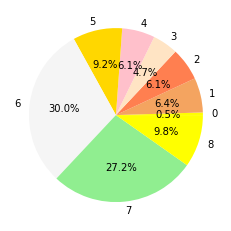

In [ ]:
labels = [0, 1, 2, 3, 4, 5, 6 ,7, 8]
colors = ['yellow', 'sandybrown', 'coral', 'bisque', 'pink', 'gold', 'whitesmoke', 'lightgreen']
plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors)
plt.show()

Text(0.5, 1.0, 'Number of objects per time period')

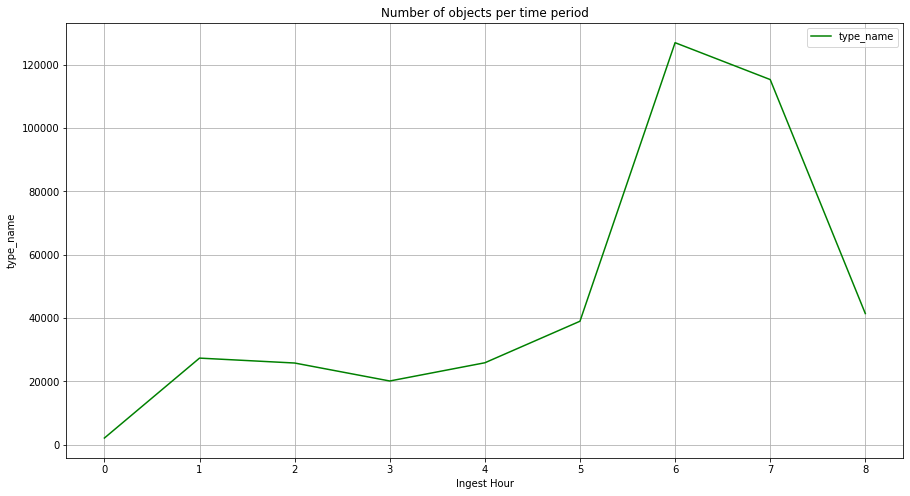

In [ ]:
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= df_train.groupby(['ingest_hour'])['type_name'].count().to_frame()
temp.plot(kind='line',color= 'g', grid=True, ax=ax,legend=True)
plt.xlabel('Ingest Hour')
plt.ylabel('type_name')
plt.title('Number of objects per time period')

In [ ]:
df_date['day'].value_counts()

2    175166
1     99789
0     70061
4     39393
3     39341
Name: day, dtype: int64

In [ ]:
ratio = []
for i in range(0,5):
  ratio.append(df_date['day'].value_counts()[i] / len_df)
print(ratio)
print(sum(ratio))

[0.16533569321533922, 0.23549026548672566, 0.4133710914454277, 0.0928401179941003, 0.09296283185840708]
1.0


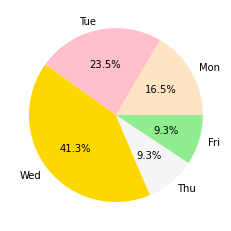

In [ ]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
colors = ['bisque', 'pink', 'gold', 'whitesmoke', 'lightgreen']
plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors)
plt.show()

Text(0.5, 1.0, 'Number of objects per day')

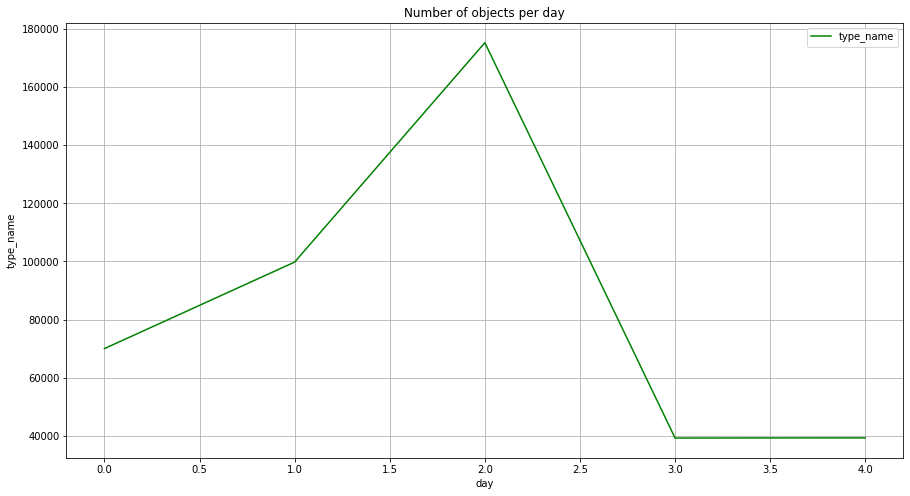

In [ ]:
df_train['day'] = df_date['day']
f, ax=plt.subplots(1,1, figsize=(15,8))
temp= df_train.groupby(['day'])['type_name'].count().to_frame()
temp.plot(kind='line',color= 'g', grid=True, ax=ax,legend=True)
plt.xlabel('day')
plt.ylabel('type_name')
plt.title('Number of objects per day')